In [9]:
import scipy
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt
from common import fast_xcorr

In [10]:
# create filter function
def butter_filter(trace, order=1, cutoff=0.01, filter_type='low', fs=None):
    """
    Apply butter filter to trace
    """
    b, a = butter(order, cutoff, btype=filter_type, fs=fs)
    trace_filtered = filtfilt(b, a, trace)
    return trace_filtered

def filter_trace(trace, filter_method):
    #debug_trace_specgram(trace, sample_rate)

    if filter_method == 'none':
        return trace
    # elif filter_method == 'ifreq':
    #     filtered_trace = ifreq(trace)
    elif filter_method == 'abs_nofilt':
        filtered_trace = np.abs(trace)
    elif filter_method == 'abs':
        filtered_trace = butter_filter(trace, 1, 0.001, 'high', None)  # Remove low freqs
        filtered_trace = np.abs(filtered_trace)
        filtered_trace = butter_filter(filtered_trace, 1, 0.001, 'high', None)  # Remove low freqs
    elif filter_method == 'complex_hp':
        filtered_trace = butter_filter(trace, 1, 0.001, 'high', None)  # Remove low freqs
    else:
        raise Exception("unknown method")
    return filtered_trace

In [11]:
def plot_trace(trace, label):
    fig, ax = plt.subplots()
    ax.plot(trace)
    ax.set_xlabel('t')
    ax.set_ylabel('am')
    ax.set_title(label)
    fig.set_size_inches(15, 5)
    plt.show()

In [12]:
#zncc 
def xcorr(template, trace):
    x = template - np.mean(template)
    res = [0]*(len(trace) - len(template)+1)
    for t in range(0, len(trace) - len(template)):
        y = trace[t:t+len(template)] - np.mean(trace[t:t+len(template)])
        res[t] = np.sum(x*y) / (np.sqrt(np.sum(x*x)*(np.sum(y*y))))
    return res

In [13]:
# try to match an AES traces
trace_path = './datasets/nodemcu-random-train2/2020-02-17_11-21-03_758355_traces.npy'
meta_path =  './datasets/nodemcu-random-train2/2020-02-17_11-21-03_758355_meta.p'

traces = np.load(trace_path, allow_pickle=True)
metas = np.load(meta_path, allow_pickle=True)

for i in range(len(metas)):
    print(i, metas[i]['op'])

aes_template = np.load('arch/nodemcu-aes-56000000.npy', allow_pickle=True)
filtered_temp = filter_trace(aes_template, 'abs')

0 aes
1 aes
2 aes
3 aes_openssl
4 hmacsha1
5 aes
6 noise
7 noise
8 sha1
9 sha1prf
10 aes_tiny
11 sha1
12 aes_tiny
13 hmacsha1
14 aes_tiny
15 sha1


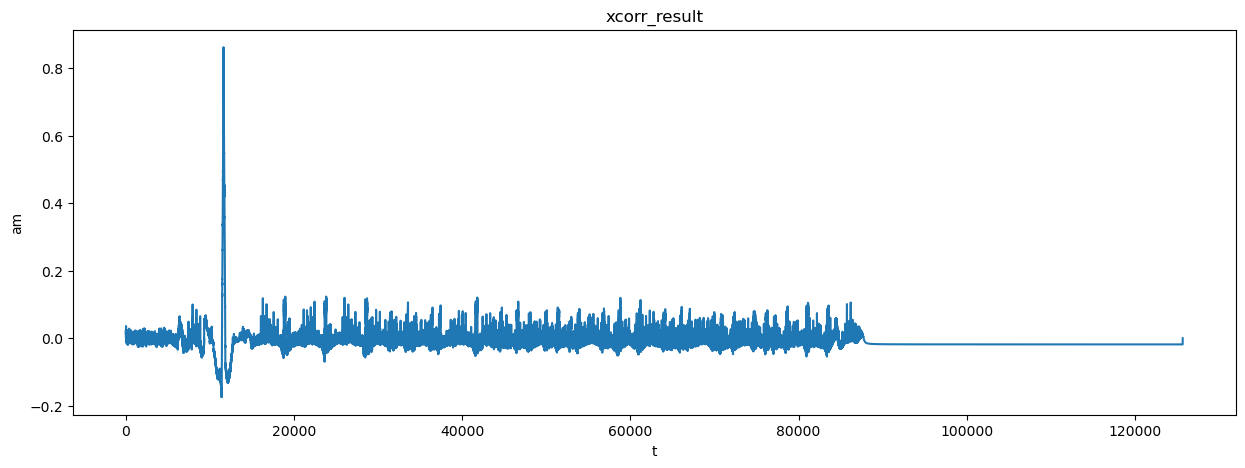

xcorr best index: 11615, max corr: 0.862156712349241


In [25]:
target_trace = traces[0]
filtered_trace = filter_trace(target_trace, 'abs')
corr_res = xcorr(filtered_temp, filtered_trace)
plot_trace(corr_res, 'xcorr_result')
print('xcorr best index: {}, max corr: {}'.format(np.argmax(corr_res), np.max(corr_res)))

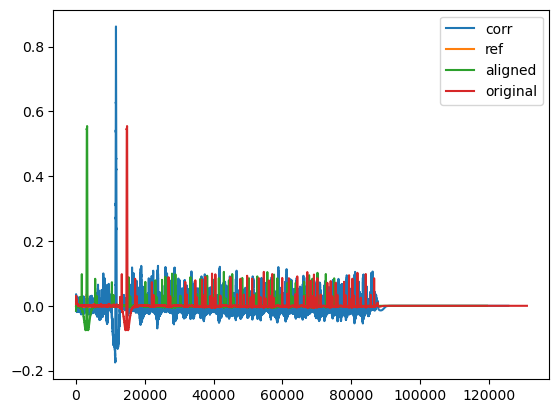

fast xcorr best index: 11615, max corr: 0.8621557228105778


In [27]:
# using fast_xcorr
start, corr = fast_xcorr(filtered_trace, filtered_temp, prefilter=False, normalized=True, return_corr_trace=False, return_corr=True, debug=True)
print('fast xcorr best index: {}, max corr: {}'.format(start, corr))

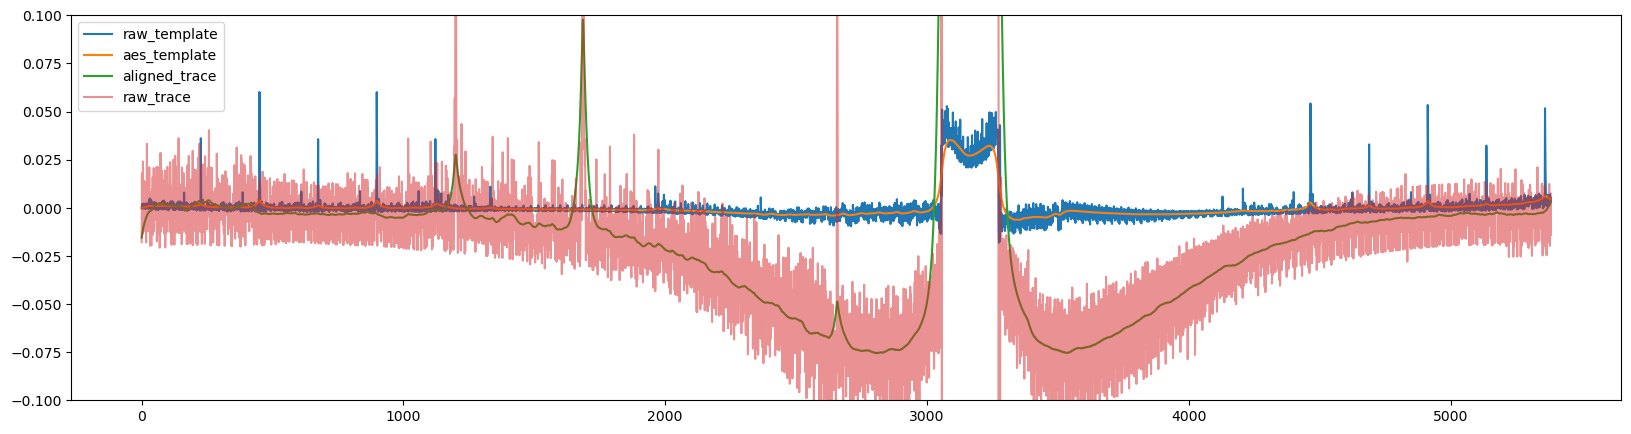

In [31]:
plt.figure(figsize=(20, 5))
plt.plot(filtered_temp, label='raw_template')
plt.plot(butter_filter(filtered_temp, 1, 0.02, 'low', None), label='aes_template')
plt.plot(butter_filter(filtered_trace[start:start+len(filtered_temp)], 1, 0.02, 'low', None), label='aligned_trace')
plt.plot(filtered_trace[start:start+len(filtered_temp)], label='raw_trace', alpha = 0.5)
# plt.plot(target_trace[start:start+len(filtered_temp)], label='unfiltered_trace')
plt.legend()
plt.setp(plt.gca().set_ylim([-0.1, 0.1]))
plt.show()